In [28]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [29]:
data_dir = "/home/wubbalubba/DL/Datasets"

train_dir = data_dir + "/train"
dev_dir = data_dir + "/dev"
test_dir = data_dir + "/test"

In [30]:
train_transforms = transforms.Compose([
    transforms.Resize(600),
    transforms.RandomCrop(500),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dev_transforms = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(600),
    transforms.CenterCrop(500),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

check_transforms = transforms.Compose([
    transforms.Resize(400),
])

In [31]:
train_ds = datasets.ImageFolder(train_dir,transform=train_transforms)

#dev_ds = datasets.ImageFolder(dev_dir,transform=dev_transforms)

test_ds = datasets.ImageFolder(test_dir,transform=test_transforms)

check_ds = datasets.ImageFolder(test_dir, transform=check_transforms)

In [32]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [33]:
weights = make_weights_for_balanced_classes(train_ds.imgs, len(train_ds.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle = False, sampler = sampler)     

/home/wubbalubba/anaconda3/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [34]:
from torch.utils.data import DataLoader

In [35]:
train_dl = DataLoader(train_ds, batch_size = 4, shuffle = True)

#dev_dl = DataLoader(dev_ds, batch_size = 2, shuffle = False)

test_dl = DataLoader(test_ds, batch_size = 4, shuffle = False)

check_dl = DataLoader(check_ds, batch_size = 1, shuffle = False)

In [36]:
train_iter = iter(train_dl)

In [37]:
X, y = next(train_iter)
print("X: {} \ny: {}".format(X.shape,y.shape))

X: torch.Size([4, 3, 500, 500]) 
y: torch.Size([4])


In [38]:
train_dl.dataset

Dataset ImageFolder
    Number of datapoints: 50
    Root Location: /home/wubbalubba/DL/Datasets/train
    Transforms (if any): Compose(
                             Resize(size=600, interpolation=PIL.Image.BILINEAR)
                             RandomCrop(size=(500, 500), padding=None)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [39]:
N_epochs = 27

In [40]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(238144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 238144)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

In [41]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 20, 3)
        self.conv4 = nn.Conv2d(20, 10, 3)
        self.fc1 = nn.Linear(10*29*29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 10*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x


net = Net2()

In [42]:
net

Net2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=8410, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [15]:
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.001,
    # momentum=0.9,
)

In [16]:
train_loss = []
valid_loss = []
for epoch in range(N_epochs):
    print(f"Epoch {epoch+1}/{N_epochs}")
    
    # Train
    net.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        
        
        optimizer.zero_grad()
        y_ = net(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(torch.exp(y_),1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
        
        
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    train_loss.append([epoch,running_loss / len(train_dl.dataset)])
    
        
    
    
    # Eval
    net.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            
            y_ = net(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
            
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    valid_loss.append([epoch,running_loss / len(test_dl.dataset)])
    
    
    

Epoch 1/27
  Train Loss: 0.5834180700778961
  Train Acc:  0.78
  Valid Loss: 0.870061723391215
  Valid Acc:  0.7
Epoch 2/27
  Train Loss: 0.40186423659324644
  Train Acc:  0.82
  Valid Loss: 0.41027634739875796
  Valid Acc:  0.7
Epoch 3/27
  Train Loss: 0.2764902663230896
  Train Acc:  0.82
  Valid Loss: 0.31925576031208036
  Valid Acc:  0.7
Epoch 4/27
  Train Loss: 0.24933145403862
  Train Acc:  0.86
  Valid Loss: 0.24345027804374694
  Valid Acc:  0.9
Epoch 5/27
  Train Loss: 0.2244319874048233
  Train Acc:  0.94
  Valid Loss: 0.23296924034754435
  Valid Acc:  0.9666666666666667
Epoch 6/27
  Train Loss: 0.15476177215576173
  Train Acc:  0.94
  Valid Loss: 0.18154163360595704
  Valid Acc:  0.9333333333333333
Epoch 7/27
  Train Loss: 0.13498144149780272
  Train Acc:  0.96
  Valid Loss: 0.18716484904289246
  Valid Acc:  0.9666666666666667
Epoch 8/27
  Train Loss: 0.13651977956295014
  Train Acc:  0.92
  Valid Loss: 0.12316915194193521
  Valid Acc:  0.9333333333333333
Epoch 9/27
  Train L

In [17]:
test_dl = DataLoader(test_ds, batch_size = len(test_ds), shuffle = False)
with torch.no_grad():# IMPORTANT
    running_loss, correct = 0.0, 0
    for X, y in test_dl:
            
            y_ = net(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
    F1ScoreMicro = f1_score(y, y_label_, average="micro")
    F1ScoreMacro = f1_score(y, y_label_, average="macro")
    F1ScoreWeighted = f1_score(y, y_label_, average="weighted")
    print(f"F1-score micro: {F1ScoreMicro}")
    print(f"F1-score macro: {F1ScoreMacro}")
    print(f"F1-score weighted: {F1ScoreWeighted}")
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print(y)
    print(y_label_)

F1-score micro: 0.8666666666666667
F1-score macro: 0.813664596273292
F1-score weighted: 0.853416149068323
  Valid Loss: 0.1643492728471756
  Valid Acc:  0.8666666666666667
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


In [18]:
test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False)
    
    

In [19]:
net1 = Net1()
train_loss1 = []
valid_loss1 = []

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(
    net1.parameters(),
    lr=0.001,
    # momentum=0.9,
)


for epoch in range(N_epochs):
    print(f"Epoch {epoch+1}/{N_epochs}")
    
    # Train
    net1.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        
        
        optimizer.zero_grad()
        y_ = net1(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(torch.exp(y_),1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
        
        
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    train_loss1.append([epoch,running_loss / len(train_dl.dataset)])
    
        
    
    
    # Eval
    net.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            
            y_ = net1(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
            
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    valid_loss1.append([epoch,running_loss / len(test_dl.dataset)])
    
    
    

Epoch 1/27
  Train Loss: 10.92179069519043
  Train Acc:  0.82
  Valid Loss: 1.9381205221017201
  Valid Acc:  0.7
Epoch 2/27
  Train Loss: 0.7246191310882568
  Train Acc:  0.82
  Valid Loss: 0.6749918699264527
  Valid Acc:  0.4666666666666667
Epoch 3/27
  Train Loss: 0.714567773938179
  Train Acc:  0.68
  Valid Loss: 0.4599911212921143
  Valid Acc:  0.8
Epoch 4/27
  Train Loss: 0.40412683129310606
  Train Acc:  0.8
  Valid Loss: 0.3310742795467377
  Valid Acc:  0.7
Epoch 5/27
  Train Loss: 0.2642049670219421
  Train Acc:  0.82
  Valid Loss: 0.2860520601272583
  Valid Acc:  0.7
Epoch 6/27
  Train Loss: 0.26898628115653994
  Train Acc:  0.82
  Valid Loss: 0.2730376958847046
  Valid Acc:  0.7
Epoch 7/27
  Train Loss: 0.4846532356739044
  Train Acc:  0.82
  Valid Loss: 0.22337884306907654
  Valid Acc:  0.9333333333333333
Epoch 8/27
  Train Loss: 0.21322089314460754
  Train Acc:  0.8
  Valid Loss: 0.2765329897403717
  Valid Acc:  0.7
Epoch 9/27
  Train Loss: 0.3544940042495728
  Train Acc:  

In [20]:
trl = np.asarray(train_loss)
tsl = np.asarray(valid_loss)
trl1 = np.asarray(train_loss1)
tsl1 = np.asarray(valid_loss1)

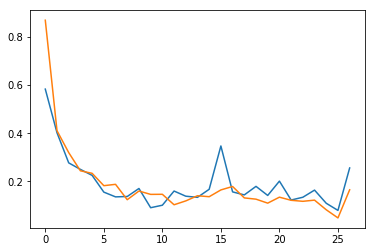

In [21]:
plt.plot(trl[:,0],trl[:,1],tsl[:,0],tsl[:,1])

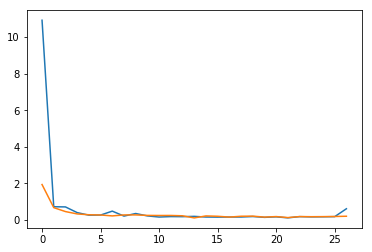

In [22]:
plt.plot(trl1[:,0],trl1[:,1],tsl1[:,0],tsl1[:,1])

In [23]:
test_dl = DataLoader(test_ds, batch_size = len(test_ds), shuffle = False)

In [24]:
with torch.no_grad():# IMPORTANT
    running_loss, correct = 0.0, 0
    for X, y in test_dl:
            
            y_ = net1(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
    F1ScoreMicro = f1_score(y, y_label_, average="micro")
    F1ScoreMacro = f1_score(y, y_label_, average="macro")
    F1ScoreWeighted = f1_score(y, y_label_, average="weighted")
    print(f"F1-score micro: {F1ScoreMicro}")
    print(f"F1-score macro: {F1ScoreMacro}")
    print(f"F1-score weighted: {F1ScoreWeighted}")
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print(y)
    print(y_label_)

F1-score micro: 1.0
F1-score macro: 1.0
F1-score weighted: 1.0
  Valid Loss: 0.20497624576091766
  Valid Acc:  1.0
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


In [25]:
10*29*29

8410

In [26]:
len(train_ds)

50

In [27]:
len(test_ds)

30